In [1]:
%load_ext autoreload
%autoreload 2

import os
from src.video_preprocessing.download_videos.youtube_download import preprocess_video
from src.video_preprocessing.scene_detection.scene_detect import detect_scenes
from src.video_preprocessing.download_videos.download_utils import (
    transcribe_audio_files,
    extract_and_store_audio,
    transcription_to_text,
)
from src.ocr.pytesseract_image_to_text import extract_text_from_image
from src.llm.ollama_implementation.ollama_experiment import (
    prompt_llm_summary,
    generate_caption_using_llava,
)

from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from PIL import Image

import torch
from loguru import logger
import pickle

from src.clip.clip_model import CLIPEmbeddingsModel

import tqdm
from pathlib import Path

# Download Pipeline
Download a video from a specific URL on YouTube, then run:
- Scene detection
- Keyframe detection

The resulting data will be stored under `/data/raw/<NAME>`

In [2]:
# Define options and input for downloading a video from youtube

# INSERT video name here
name = "biology_chapter_3_3"
# INSERT video URL here
url = "https://youtu.be/DZSEErNZ1d4?si=f6YxKQ9rP6iqgTfk"
# INSERT chunk length in seconds 30s --> 30, no splitting: None
chunks = None

opts_aud = {"format": "mp3/bestaudio/best", "keep-video": True}
opts_vid = {"format": "mp4/bestvideo/best"}

In [3]:
# Downloads the video creates the relevant datafolders and transcribes the video
data_path = preprocess_video(
    download=True,
    uploaded_vid="ignore",  # path to local file
    url=url,
    name=name,
    aud_opts=opts_aud,
    vid_opts=opts_vid,  # Video download settings
    audio_file=name + ".mp3",
    input_file=name + ".mp4",
    output="output.mp4",
    split_length=chunks,
)

2024-06-26 11:12:32.228 | INFO     | src.video_preprocessing.download_videos.youtube_download:preprocess_video:49 - Starting AutoCaptioning...
2024-06-26 11:12:32.243 | INFO     | src.video_preprocessing.download_videos.youtube_download:preprocess_video:50 - Results will be stored in data/raw/biology_chapter_3_3
2024-06-26 11:12:32.243 | INFO     | src.video_preprocessing.download_videos.youtube_download:preprocess_video:58 - Created chunks folders


[youtube] Extracting URL: https://youtu.be/DZSEErNZ1d4?si=f6YxKQ9rP6iqgTfk
[youtube] DZSEErNZ1d4: Downloading webpage
[youtube] DZSEErNZ1d4: Downloading ios player API JSON
[youtube] DZSEErNZ1d4: Downloading m3u8 information
[info] DZSEErNZ1d4: Downloading 1 format(s): 18
[download] C:\Users\baatout\PycharmProjects\afm-vlm\data\raw\biology_chapter_3_3\biology_chapter_3_3.mp4 has already been downloaded
[download] 100% of   85.73MiB


2024-06-26 11:12:35.519 | INFO     | src.video_preprocessing.download_videos.youtube_download:preprocess_video:91 - Video is not splitted:
2024-06-26 11:12:35.519 | INFO     | src.video_preprocessing.download_videos.youtube_download:preprocess_video:95 - Video downloaded successfully!


In [ ]:
#  Now that we have downloaded the video we want to perform scene_Detection:
detect_scenes(data_path)

2024-06-25 20:21:09.819 | INFO     | src.video_preprocessing.scene_detection.scene_detect:detect_scenes:29 - Found file
2024-06-25 20:21:09.835 | INFO     | src.video_preprocessing.scene_detection.scene_detect:detect_scenes:33 - Name:biology_chapter_3_3.mp4,dirname:C:\Users\baatout\PycharmProjects\afm-vlm\data/raw\biology_chapter_3_3\biology_chapter_3_3.mp4
2024-06-25 20:21:09.837 | INFO     | src.video_preprocessing.scene_detection.scene_detect:detect_scenes:35 - Running scene_detection:


In [ ]:
# Extract the audio per detected scene
extract_and_store_audio(
    os.path.join(data_path, "scene_snippets"),
    os.path.join(data_path, "audio_chunks"),
)

# Audio Transcription using Whisper

For Faster Inference Please Use Tiny!

In [12]:
# Transcribe the different snippets:
audio_dir = os.path.join(data_path, "audio_chunks")
transcriptions_dir = os.path.join(data_path, "transcriptions")

model_type = "tiny"  # change to 'large' if you want more accurate results,
# change to 'medium.en' or 'large.en' for all english language tasks,
# and change to 'small' or 'base' for faster inference
lang = "en"

# Run whisper on all .wav files in audio_dir
transcribe_audio_files(audio_dir, transcriptions_dir, model_type=model_type, lang=lang)

2024-06-25 23:57:07.443 | INFO     | src.video_preprocessing.download_videos.download_utils:transcribe_audio_files:361 - Starting pooling:
100%|██████████| 141/141 [04:53<00:00,  2.08s/it]


# Load the CLIP Model

In [4]:
# create instance
clip_model = CLIPEmbeddingsModel()

<Figure size 800x2000 with 0 Axes>

In [5]:
# get current directory
# Get the path of the current notebook
notebook_path = Path().resolve()
image_path = os.path.join(
    notebook_path, "data", "raw", "biology_chapter_3_3", "extracted_keyframes"
)

images = []
# make a list out of the images
for image in os.listdir(image_path):
    if image.endswith(".jpg"):
        images.append(os.path.join(image_path, image))

# load and process the dataset
image_dataset = clip_model.load_and_process_dataset(images)

logger.info(f"Image_dataset: {image_dataset}")

2024-06-26 11:12:42.635 | INFO     | __main__:<module>:17 - Image_dataset: [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237CAB1BCE0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237CAB1BCB0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237CAAFDDC0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237CAAFDD30>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237CAAFDCA0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237CAAFDC10>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237CAAFDB80>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237CAAFDAC0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237CAAFDA00>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237CAAFD910>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237CAAFD820>, <PIL.JpegImagePlugin.J

# Starting the Analysis of the Information Contained in the Video

### Inputs

* **Transcriptions**: [insert description or link to transcription]
* **Extraction from Slides using OCR**: [insert description or link to extracted content]
* **Textual Interpretation of Visual Information using LLAVA**: [insert description or link to 
interpreted information]

In [ ]:
import json
import tqdm
import os
from src.llm.ollama_implementation.ollama_experiment import (
    prompt_llm_summary,
    generate_caption_using_llava,
    prompt_llm_extensive_summary,
)
from src.video_preprocessing.download_videos.download_utils import (
    transcription_to_text,
    create_metadata,
)

# Transform transcription file
keyframes = {}
ocr_extracted_text = []

for filename in tqdm.tqdm(os.listdir(image_path)):
    # Check if the file ends with the specified extension
    if filename.endswith(".jpg"):
        filepath = os.path.join(image_path, filename)
        keyframe_num = int(filename.split("-")[2])

        # Extract text using OCR:
        ocr_text = extract_text_from_image(filepath)

        # logger.info(f"OCR_results: {ocr_text}")

        transcription_file_path = os.path.join(
            os.path.dirname(image_path),
            "transcriptions",
            filename.replace("-01.jpg", ".csv"),
        )

        transcription, timestamps = transcription_to_text(transcription_file_path)
        logger.info(f"Transcription_text: {transcription}")

        # Extract textual understanding of Visual features using LLAVA:

        #llava_results = generate_caption_using_llava(filepath)
        llava_results = "llava_results"
        logger.info(f"LLava_results: {llava_results}")

        clip_llm_summary = prompt_llm_summary(
            slide_content=ocr_text,
            transcription=transcription,
            llava_output=llava_results,
        )

        extensive_summary = prompt_llm_extensive_summary(
            slide_content=ocr_extracted_text,
            transcription=transcription,
            llava_output=llava_results,
        )

        # Alternative that goes faster.
        # ocr_text = "ocr_text"
        # llava_results = "llava_results"
        # clip_llm_summary = "clip_llm_summary"
        # extensive_summary = "extensive_summary"

        # generate embeddings
        opened_image = Image.open(filepath)

        embeddings = clip_model.generate_image_embeddings(
            clip_llm_summary, opened_image
        )
        clip_text_embedding = embeddings["text_embeds"]
        clip_image_embedding = embeddings["image_embeds"]

        keyframe, keyframe_metadata = create_metadata(
            keyframe_num,
            filepath,
            timestamps,
            transcription,
            ocr_extracted_text,
            llava_results,
            clip_llm_summary,
            extensive_summary,
            clip_text_embedding,
            clip_image_embedding,
        )
        keyframes[keyframe] = keyframe_metadata
        # print(keyframes)

    # Save keyframes dictionary as Pickle

# Save with pickle
with open("data.pickle", "wb") as file:
    pickle.dump(keyframes, file)

  0%|          | 0/143 [00:00<?, ?it/s]2024-06-26 11:06:04.504 | INFO     | src.ocr.pytesseract_image_to_text:extract_text_from_image:17 - Extracted text: Chapter 3:

Nutrients & Membrane Transport
**Is It Possible to Supplement Your
Way to Better Performance & Health?

Biology 1020:
CURRENT TOPICS IN
BIOLOGY


2024-06-26 11:06:04.519 | INFO     | __main__:<module>:36 - Transcription_text:  Welcome to Chapter 3, Nutrients, Membranes and Trane.
2024-06-26 11:06:04.527 | INFO     | __main__:<module>:42 - LLava_results: llava_results


In [3]:
# Assuming keyframes is your dictionary
keyframes_count = len(keyframes)
print("Number of keyframes:", keyframes_count)

NameError: name 'keyframes' is not defined

# Test 1: Search for exact similar Text.

In [42]:
# print pickle file 
with open("data.pickle", "rb") as file:
    data = pickle.load(file)

extracted_data_text = [data[key]['clip_text_embedding'] for key in data.keys() if
                       'clip_text_embedding' in data[key]]

extracted_data_path = [data[key]['img_path'] for key in data.keys() if
                       'img_path' in data[key]]

clip_text_embeddings = [data[0] for data in extracted_data_text]

image_paths = [data[1] for data in extracted_data_path]

clip_model.text_embeddings = clip_text_embeddings
clip_model.img_paths = extracted_data_path

logger.info(f"clip_model.embeddings: {clip_model.embeddings}")

2024-06-26 11:52:55.588 | INFO     | __main__:<module>:18 - clip_model.embeddings: [tensor([[-6.7389e-03,  3.6235e-02, -3.1279e-02,  2.3946e-03, -1.0474e-03,
          2.4778e-02, -1.0593e-02,  1.3865e-01,  3.9337e-02, -3.8960e-02,
          3.6836e-03,  3.8811e-02, -1.1643e-02,  2.2407e-02, -1.1284e-03,
          4.9348e-02, -4.6133e-03,  5.8976e-04,  2.2234e-03,  2.0709e-02,
         -2.7333e-02,  3.0508e-02, -7.1299e-03, -1.7552e-02,  3.4070e-02,
         -2.5812e-02,  8.1246e-03, -4.2822e-02, -1.0977e-02, -1.5935e-02,
          1.0361e-02, -1.8723e-02, -4.4892e-02, -5.0754e-03, -3.9631e-02,
          3.2289e-02, -4.8706e-02,  3.8960e-02, -8.0543e-03, -3.7494e-02,
          1.9277e-02, -2.6574e-02, -1.3198e-02,  3.0107e-02,  4.1050e-02,
         -7.4078e-03,  4.2456e-02, -3.4931e-02, -2.7494e-02, -6.2412e-02,
         -1.0101e-02,  6.3677e-02, -2.7979e-04,  1.8227e-02, -4.5735e-04,
         -6.1548e-03, -2.4268e-03, -7.4170e-03,  1.1224e-03,  1.4219e-03,
          5.9924e-02, -3.043

In [45]:
if isinstance(clip_model.text_embeddings, list):
    for i, text_embedding in enumerate(clip_model.text_embeddings):
        clip_model.text_embeddings[i] = torch.tensor(text_embedding)

# create one single torch for sim search 
clip_model.text_embeddings = torch.stack(clip_model.text_embeddings, dim=0)
print(clip_model.text_embeddings.shape)

torch.Size([142, 512])


2024-06-26 11:59:28.775 | INFO     | src.ocr.pytesseract_image_to_text:extract_text_from_image:17 - Extracted text: Cell Structure

* Subcellular structures
— Cell wall: protection outside the plasma membrane for
plants, fungi, and bacteria; provides structural support
— Nucleus: holds chromatin (DNA and proteins) in
eukaryotic cells; surrounded by nuclear envelope
— Nucleolus: synthesizes ribosomes; inside nucleus


2024-06-26 11:59:28.779 | INFO     | src.clip.clip_model:search_similar_images:161 - Text embeddings torch.Size([142, 512])
2024-06-26 11:59:28.915 | INFO     | src.clip.clip_model:search_similar_images:168 - Similarity scores: tensor([0.6981, 0.6046, 0.6530, 0.6884, 0.6611, 0.7018, 0.6211, 0.7190, 0.6568,
        0.6562, 0.6920, 0.6503, 0.6936, 0.6671, 0.6410, 0.6227, 0.7694, 0.7773,
        0.7936, 0.7913, 0.7468, 0.7609, 0.6842, 0.6209, 0.7844, 0.6432, 0.7397,
        0.6394, 0.6628, 0.7477, 0.5994, 0.7246, 0.6881, 0.7806, 0.6361, 0.6445,
        0.6585, 0.7180, 0.9095,

Test Text Description:  Cell Structure

* Subcellular structures
— Cell wall: protection outside the plasma membrane for
plants, fungi, and bacteria; provides structural support
— Nucleus: holds chromatin (DNA and proteins) in
eukaryotic cells; surrounded by nuclear envelope
— Nucleolus: synthesizes ribosomes; inside nucleus




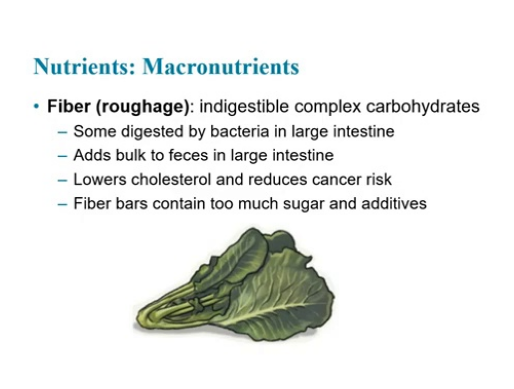

In [49]:
import torch
import torch.nn.functional as F

base_dir = "../.."

test_image_path = os.path.join(
    base_dir,
    "data",
    "raw",
    "biology_chapter_3_3",
    "extracted_keyframes",
    "biology_chapter_3_3-Scene-097-01.jpg",
)

test_text_description = extract_text_from_image(test_image_path)

print("Test Text Description: ", test_text_description)
# set the model embeddings
# Search for similar images in database
clip_model.search_similar_images(test_text_description)

# Test 2: Search for for a slightly different Text.

2024-06-26 11:38:32.960 | INFO     | src.clip.clip_model:search_similar_images:161 - Text embeddings torch.Size([142, 512])
2024-06-26 11:38:33.040 | INFO     | src.clip.clip_model:search_similar_images:169 - Similarity scores: tensor([0.7059, 0.6940, 0.6447, 0.6421, 0.6087, 0.5919, 0.6346, 0.7208, 0.7108,
        0.6299, 0.6722, 0.6256, 0.6984, 0.7241, 0.6122, 0.6043, 0.6348, 0.7533,
        0.7228, 0.7230, 0.7178, 0.6804, 0.6504, 0.5966, 0.7127, 0.6174, 0.6982,
        0.6000, 0.6459, 0.7653, 0.6763, 0.7074, 0.6663, 0.7832, 0.6249, 0.5929,
        0.6361, 0.7046, 0.7446, 0.7003, 0.7177, 0.6629, 0.6579, 0.5815, 0.6804,
        0.6047, 0.5382, 0.7282, 0.6776, 0.6707, 0.7905, 0.5982, 0.5922, 0.6963,
        0.7269, 0.7356, 0.6303, 0.6203, 0.6626, 0.6241, 0.6523, 0.5717, 0.7355,
        0.6108, 0.7483, 0.6898, 0.6446, 0.8103, 0.6215, 0.6647, 0.7186, 0.7538,
        0.7222, 0.7435, 0.7269, 0.6236, 0.6970, 0.6476, 0.5833, 0.6019, 0.6567,
        0.7428, 0.6536, 0.6539, 0.6171, 0.7151, 0.73

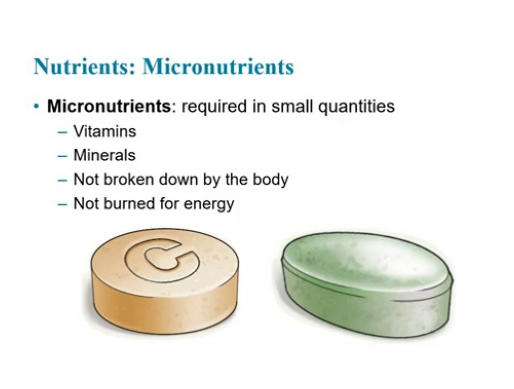

In [27]:
query_text = "plasma membrane and stuff going on"

clip_model.search_similar_images(query_text)

# Test-Case 1: Search for a completely different Text.

